In [10]:
# Importing modules
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

Populating interactive namespace

In [11]:
# Read datasets/papers.csv into papers

papers = pd.read_csv('datasets/papers.csv', error_bad_lines=False)

# Print out the first rows of papers
print(papers.head())

     id  year                                              title event_type  \
0     1  1987  Self-Organization of Associative Database and ...        NaN   
1    10  1987  A Mean Field Theory of Layer IV of Visual Cort...        NaN   
2   100  1988  Storing Covariance by the Associative Long-Ter...        NaN   
3  1000  1994  Bayesian Query Construction for Neural Network...        NaN   
4  1001  1994  Neural Network Ensembles, Cross Validation, an...        NaN   

                                            pdf_name          abstract  \
0  1-self-organization-of-associative-database-an...  Abstract Missing   
1  10-a-mean-field-theory-of-layer-iv-of-visual-c...  Abstract Missing   
2  100-storing-covariance-by-the-associative-long...  Abstract Missing   
3  1000-bayesian-query-construction-for-neural-ne...  Abstract Missing   
4  1001-neural-network-ensembles-cross-validation...  Abstract Missing   

                                          paper_text  
0  767\n\nSELF-ORGANIZATI

Read in data from research papers, view columns and data types

In [12]:
# Remove the columns
papers = papers.drop(['id','event_type','pdf_name'], axis=1)

# Print out the first rows of papers
print(papers.head())

   year                                              title          abstract  \
0  1987  Self-Organization of Associative Database and ...  Abstract Missing   
1  1987  A Mean Field Theory of Layer IV of Visual Cort...  Abstract Missing   
2  1988  Storing Covariance by the Associative Long-Ter...  Abstract Missing   
3  1994  Bayesian Query Construction for Neural Network...  Abstract Missing   
4  1994  Neural Network Ensembles, Cross Validation, an...  Abstract Missing   

                                          paper_text  
0  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...  
1  683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...  
2  394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...  
3  Bayesian Query Construction for Neural\nNetwor...  
4  Neural Network Ensembles, Cross\nValidation, a...  


Dropped garbage features from dataframe

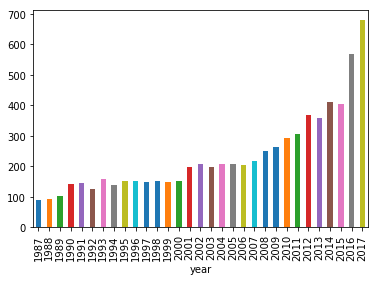

In [6]:
# Group the papers by year
groups = papers.groupby('year')

# Determine the size of each group
counts = groups.size()

# Visualise the counts as a bar plot
import matplotlib.pyplot
%matplotlib inline
counts.plot(kind='bar')

Grouped data by year and counted the number of research papers by year. Plotted a bar plot with counts of number of papers by year.

In [7]:
# Load the regular expression library
import re

# Print the titles of the first rows
print(papers['paper_text'].head())

0    767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1    683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2    394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3    Bayesian Query Construction for Neural\nNetwor...
4    Neural Network Ensembles, Cross\nValidation, a...
Name: paper_text, dtype: object


View titles of rows again to see what expressions to remove and remove unwanted expressions

In [14]:
# Print the text of the first rows
print('Before')
print(papers['paper_text'].head())

# Remove punctuation
papers['text_processed'] = papers['paper_text'].map(lambda x: re.sub('[,\.!?"()@:;~/]', ' ', x))

# Remove words with string size less than 3
papers['text_processed'] = papers['text_processed'].map(lambda x: re.sub(r'\b\w{,3}\b', '', x))

# Remove tabs, newlines, whitespace-like from text
papers['text_processed']=papers['text_processed'].map(lambda x: re.sub('\s+', ' ', x).strip())

# Convert the titles to lowercase
papers['text_processed'] = papers['text_processed'].map(lambda x:x.lower())

# Print the processed titles of the first rows
print('After')
print(papers['text_processed'].head())

Before
0    767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1    683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2    394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3    Bayesian Query Construction for Neural\nNetwor...
4    Neural Network Ensembles, Cross\nValidation, a...
Name: paper_text, dtype: object
After
0    self-organization associative database applica...
1    mean field theory layer visual cortex applicat...
2    storing covariance associative long term poten...
3    bayesian query construction neural network mod...
4    neural network ensembles cross validation acti...
Name: text_processed, dtype: object


Removed several layers of unneccessary information from research paper text.

In [19]:
# Separate via decade
papers.loc[papers['year']<=2017,'decade']='2007-2017'
papers.loc[papers['year']<2007,'decade']='1997-2006'
papers.loc[papers['year']<1997,'decade']='1987-1996'

# Join the different processed texts together, sampling by decade
papers1 = pd.pivot_table(papers, values='text_processed', index='decade',
                         aggfunc=' '.join)

Separated dataset into decades to view machine learning word usage by decade

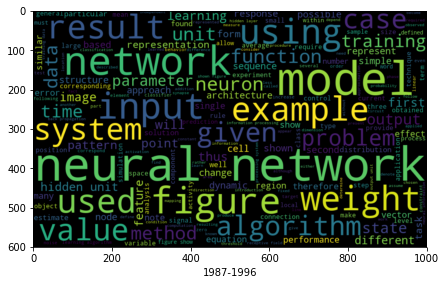

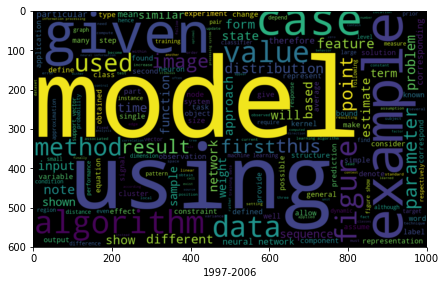

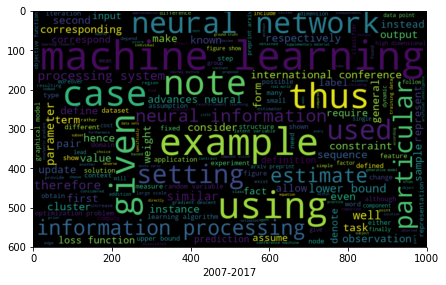

In [20]:
# Generate a word cloud for each decade

for idx in papers1.index:
    wc=WordCloud(width=1000,
                 height=600,
                 background_color='black',
                 stopwords=STOPWORDS)
    wc.generate(papers1['text_processed'].loc[idx])
    plt.imshow(wc, interpolation='bilinear')
    plt.xlabel(idx)
    plt.tight_layout(pad=0)
    plt.show()

Created word clouds of the different word usage in each decade of machine learning research.

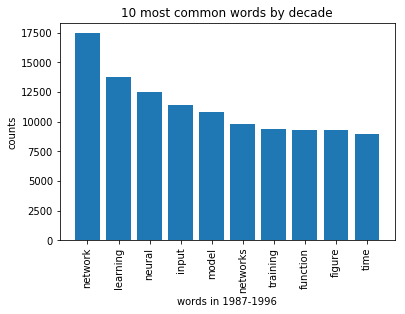

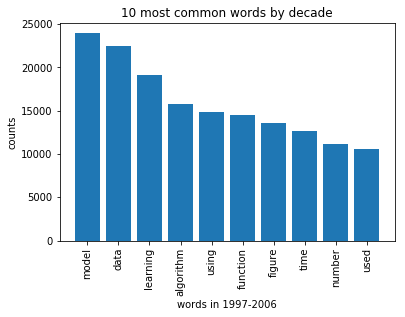

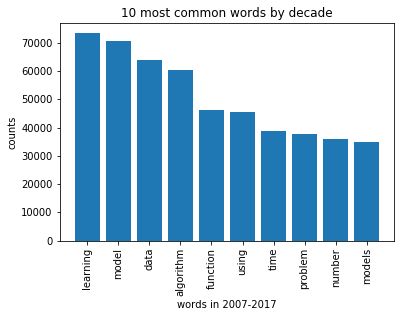

In [21]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer, decade):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))

    plt.bar(x_pos, counts,align='center')
    plt.xticks(x_pos, words, rotation=90)
    plt.xlabel('words in %s' %(decade))
    plt.ylabel('counts')
    plt.title('10 most common words by decade')
    plt.show()

# Create a loop to iterate over each decade
for idx in papers1.index:
    # Initialise the count vectorizer with the English stop words
    count_vectorizer = CountVectorizer(stop_words='english')

    # Fit and transform the processed titles
    count_data = count_vectorizer.fit_transform([papers1['text_processed'].loc[idx]])

    # Visualise the 10 most common words by decade
    plot_10_most_common_words(count_data, count_vectorizer, idx)

We plot the count of the top 10 word usage by decade in the research papers. It seems focus slowly went from 'neural' and 'networks' to 'model' and 'data' and lastly 'learning' and 'model'. It seems in the earliest decade, algorithms were not as commonly studied as in the latter two decades.

In [27]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Tweak the two parameters below (use int values below 15)
number_topics = 10
number_words = 6

# Create a loop to iterate over each decade
for idx in papers1.index:
    count_vectorizer = CountVectorizer(stop_words='english')
    count_data = count_vectorizer.fit_transform([papers1['text_processed'].loc[idx]])

    # Create and fit the LDA model
    lda = LDA(n_components=number_topics)
    lda.fit(count_data)

    # Print the words found by the LDA model
    print("\n\nTop words used between %s via LDA:" %(idx))
    print_topics(lda, count_vectorizer, number_words)



Top words used between 1987-1996 via LDA:

Topic #0:
network learning neural input model networks

Topic #1:
network input neural networks learning training

Topic #2:
network learning model neural figure input

Topic #3:
network learning neural input training model

Topic #4:
networks learning network input function output

Topic #5:
learning network input neural model figure

Topic #6:
network learning input model neural function

Topic #7:
learning network neural model figure input

Topic #8:
network learning training networks function input

Topic #9:
network neural learning input model used


Top words used between 1997-2006 via LDA:

Topic #0:
model data learning using algorithm time

Topic #1:
data model learning algorithm time given

Topic #2:
data using model learning time function

Topic #3:
model data learning using figure function

Topic #4:
model learning data function time algorithm

Topic #5:
model learning data figure algorithm using

Topic #6:
model data learning alg

Using LDA, or latent direchlet allocation, we can now perform topic detection on the research paper dataset. LDA can determine what the main 'topics' are in a large unlabeled set of texts. A 'topic' is a collection of words that tend to co-occur often. The hypothesis is that LDA might be able to clarify what the different topics in the research titles are. These topics can then be used as a starting point for further analysis.